In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
url='https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv'
df = pd.read_csv(url, header=None, na_values='?')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,2.0,1,530101,38.5,66.0,28.0,3.0,3.0,NaN,2.0,...,45.0,8.4,NaN,NaN,2.0,2,11300,0,0,2
1,1.0,1,534817,39.2,88.0,20.0,NaN,NaN,4.0,1.0,...,50.0,85.0,2.0,2.0,3.0,2,2208,0,0,2
2,2.0,1,530334,38.3,40.0,24.0,1.0,1.0,3.0,1.0,...,33.0,6.7,NaN,NaN,1.0,2,0,0,0,1
3,1.0,9,5290409,39.1,164.0,84.0,4.0,1.0,6.0,2.0,...,48.0,7.2,3.0,5.3,2.0,1,2208,0,0,1
4,2.0,1,530255,37.3,104.0,35.0,NaN,NaN,6.0,2.0,...,74.0,7.4,NaN,NaN,2.0,2,4300,0,0,2


In [3]:
print(df.isna().sum())

0       1
1       0
2       0
3      60
4      24
5      58
6      56
7      69
8      47
9      32
10     55
11     44
12     56
13    104
14    106
15    247
16    102
17    118
18     29
19     33
20    165
21    198
22      1
23      0
24      0
25      0
26      0
27      0
dtype: int64


In [4]:
X = df.iloc[:,:27]
y = df.iloc[:,27]
display(X.shape, y.shape)
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.3)
display(X_train.shape, y_train.shape, X_test.shape, y_true.shape)

(300, 27)

(300,)

(210, 27)

(210,)

(90, 27)

(90,)

In [5]:
rng = np.random.RandomState()
#train_
scores = []
test_scores = []
cv = KFold(random_state=rng, shuffle=True)
rf = RandomForestClassifier(random_state=rng)

# Simple Imputer

In [6]:
strategies = ['mean', 'median', 'most_frequent', 'constant']

for s in strategies:
    pipe_si = Pipeline(steps = [('imputer', SimpleImputer(strategy=s)),('model', rf)])
    score = cross_val_score(pipe_si, X_train, y_train, cv=cv, scoring='accuracy')
    print("score >%s,  %.3f"%(s, score.mean()))
    scores.append(((s.capitalize()+"_SI"), score.mean(), score.std()))
    



score >mean,  0.852
score >median,  0.829
score >most_frequent,  0.871
score >constant,  0.871


# End of tail Imputation

In [7]:
def max_end_tail_imputation(df):
    for col in df.columns.tolist():
        extreme = df[col].mean()+3*df[col].std()
        df.loc[:,col] = df.loc[:,col].fillna(extreme)
    return df
def min_end_tail_imputation(df):
    for col in df.columns.tolist():
        extreme = df[col].mean()-3*df[col].std()
        df.loc[:, col] = df.loc[:,col].fillna(extreme)
    return df

In [8]:
X_max_impute = max_end_tail_imputation(X_train)
X_min_impute = min_end_tail_imputation(X_train)
score_max = cross_val_score(rf, X_max_impute, y_train, cv=cv, scoring='accuracy')
print("score> Max End of tail imputation %.3f"%(score_max.mean()))
score_min = cross_val_score(rf, X_min_impute, y_train, cv=cv, scoring='accuracy')
print("score> Min End of tail imputation %.3f"%(score_min.mean()))
scores.extend([('Max End of tail emputation', score_max.mean(), score_max.std()),
               ('Min End of tail emputation', score_min.mean(), score_min.std())])

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


score> Max End of tail imputation 0.881
score> Min End of tail imputation 0.848


# Iterative Imputer

models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X.

In [9]:
itimpute = IterativeImputer(add_indicator=True, n_nearest_features=5, sample_posterior=True, max_iter=20)
pipe_it = Pipeline(steps = [('imputer', itimpute),('model', rf)])
score_it = cross_val_score(pipe_it, X_train, y_train, cv=cv, scoring='accuracy')
print("Iterative Imputer Score> %.3f"%(score_it.mean()))
scores.append(("Iterative Imputer", score_it.mean(), score_it.std()))

Iterative Imputer Score> 0.871


# KNN Imputer

In [10]:
knnimpute = KNNImputer(add_indicator=True, n_neighbors=5)
pipe_knn = Pipeline(steps = [('imputer', knnimpute),('model', rf)])
score_knn = cross_val_score(pipe_knn, X_train, y_train, cv=cv, scoring='accuracy')
print("KNN Imputer Score> %.3f"%(score_knn.mean()))
scores.append(("KNN Imputer", score_knn.mean(), score_knn.std()))


KNN Imputer Score> 0.881


# Random Sample Imputer

In [11]:
def random_sample_imputation(df):
    for col in df.columns.tolist():
        random_sample = df[col].dropna().sample(df[col].isnull().sum())
        random_sample.index = df[df[col].isnull()].index
        df.loc[df[col].isnull(), col] = random_sample
    return df

In [12]:
X_random_impute = random_sample_imputation(X_train)
score_random = cross_val_score(rf, X_random_impute, y_train, cv=cv, scoring='accuracy')
print("score> Random Sample imputation %.3f"%(score_random.mean()))
scores.append(('Random Sample Imputation', score_random.mean(), score_random.std()))

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


score> Random Sample imputation 0.857


In [13]:
scores

[('Mean_SI', 0.8523809523809524, 0.05909368402852791),
 ('Median_SI', 0.8285714285714285, 0.04096345365258394),
 ('Most_frequent_SI', 0.8714285714285713, 0.07158712561129957),
 ('Constant_SI', 0.8714285714285713, 0.03229680944345365),
 ('Max End of tail emputation', 0.880952380952381, 0.07377111135633174),
 ('Min End of tail emputation', 0.8476190476190476, 0.05128728387747147),
 ('Iterative Imputer', 0.8714285714285716, 0.01904761904761907),
 ('KNN Imputer', 0.880952380952381, 0.06208764195431097),
 ('Random Sample Imputation', 0.8571428571428571, 0.0499432784842929)]

# Plot a bar chart

<BarContainer object of 9 artists>

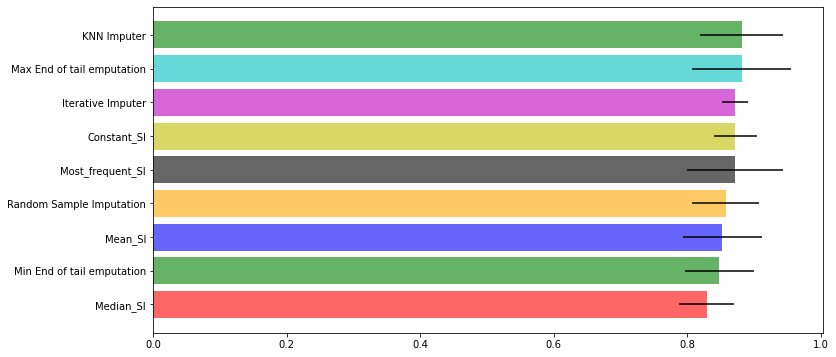

In [14]:
label = []
score_v = []
stds = []

for name, val, std in sorted(scores, key = lambda a:a[1]):
    label.append(name)
    score_v.append(val)
    stds.append(std)

colors = colors = ['r', 'g', 'b', 'orange', 'black','y', 'm','c', 'g']
plt.figure(figsize=(12,6))
plt.barh(label, score_v, color=colors, alpha=0.6, align='center', xerr=stds)



In [15]:
sorted(scores, key = lambda a:a[1], reverse=True)

[('Max End of tail emputation', 0.880952380952381, 0.07377111135633174),
 ('KNN Imputer', 0.880952380952381, 0.06208764195431097),
 ('Iterative Imputer', 0.8714285714285716, 0.01904761904761907),
 ('Most_frequent_SI', 0.8714285714285713, 0.07158712561129957),
 ('Constant_SI', 0.8714285714285713, 0.03229680944345365),
 ('Random Sample Imputation', 0.8571428571428571, 0.0499432784842929),
 ('Mean_SI', 0.8523809523809524, 0.05909368402852791),
 ('Min End of tail emputation', 0.8476190476190476, 0.05128728387747147),
 ('Median_SI', 0.8285714285714285, 0.04096345365258394)]